# Section 10

## Preliminaries

### Data Sources
This repository contains a file named `spectrum.dat`, which you will need for the excercises in this section.

## Assignment

Use the [EMCEE](http://dfm.io/emcee/current/) package to apply a MCMC analysis to fit a two-Gaussian emission line model to the spectrum data in `spectrum.dat` available on the repository. Only focus on the wavelength range $6780 \le \lambda ($Å$) \le 6860$.
1. Start by defining the model for the spectrum data. As you recall, the model can have 6-7 parameters. To make your first experience with MCMC simpler, lets reduce the number of parameters:
    * Fix the wavelength for _Line #1_ to $\lambda = 6811.133$ Å.
    * Fix the wavelength for _Line #2_ to  $\lambda = 6825.906$ Å.
    * Fix Width of both lines to be the same, $\sigma_1 = \sigma_2$.
    * Fix Ratio of line strengths to $A_2 / A_1 = 0.9111$.
    * Fix Continuum in the range $6780 < \lambda < 6860$ to be flat.
2. Define prior and likelihood functions and setup the MCMC analysis.
3. Choose an appropriate number of walkers and use `emcee` to compute a MCMC chain of an appropriate length. You can assume the errors on the flux values to be approximately Gaussian, with $\sigma = 0.2\cdot\sqrt{f_{sky}}$ (Use the column labelled `SkyFlux` in the data file).
4. Plot the paths traced by the MCMC walkers through the parameter space.
5. Plot the individal distributions and the the joint distributions for the parameters.
6. Report your final best-fit values along with proper error bars.
7. Answer the following in context of the problem:
    * What happens if you reduce your errors by a factor of 10?
    * What happens when you change the prior?
    * What happens when you change the initial positions of your walkers?
    * What happens when you change the number of walkers?
    * How long of a 'burn-in' phase is required?
    * Is there any correlation between parameters?

Need more information? One of the _Data Mining_ book's authors whas written [a good reference](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) on how to be a Bayesian in Python!

In [1]:
import emcee
import numpy as np
import astropy as ap
import astropy.io.ascii as apascii
import astropy.table as aptable
import scipy.optimize as spopt
import scipy.stats as spstats
import matplotlib.pyplot as mplplot
import itertools
import corner
from IPython.core.display import display
from IPython.display import Latex

%matplotlib inline
%load_ext lab_black

Read the `spectrum.dat` file using the `astropy.io.ascii` module and get a list of the columns it contains.

In [2]:
spectrumDataTable = apascii.read("spectrum.dat")
print("Table columns:", *spectrumDataTable.columns, sep="\n")

Table columns:
Wavelength
Flux
BestFit
SkyFlux


Plot the `Wavelength` and `Flux` columns to view the spectrum.

In [3]:
def plotSpectrum(
    spectrumData, filterZeroSkyFlux=False, errors=False, model=False
):
    spectrumAxes = mplplot.figure(figsize=(8, 6)).add_subplot(1, 1, 1)

    if filterZeroSkyFlux:
        spectrumData = spectrumData.copy()[spectrumData["SkyFlux"] > 0]

    spectrumAxes.scatter(
        x=spectrumData["Wavelength"],
        y=spectrumData["Flux"],
        label="Spectrum",
        s=3,
        c="C0",
    )
    if errors and "FluxError" in spectrumData.columns:
        spectrumAxes.errorbar(
            spectrumData["Wavelength"],
            spectrumData["Flux"],
            yerr=spectrumData["FluxError"],
            label=None,
            c="C0",
        )

    if model and "BestFit" in spectrumData.columns:
        spectrumAxes.plot(
            spectrumData["Wavelength"],
            spectrumData["BestFit"],
            label="Best fit from file",
            c="C1",
            zorder=100,
        )

    spectrumAxes.set_xlabel("Wavelength ($\AA$)")
    spectrumAxes.set_ylabel("Flux (Arbitrary Units)")
    spectrumAxes.legend()
    mplplot.tight_layout()

    return spectrumAxes

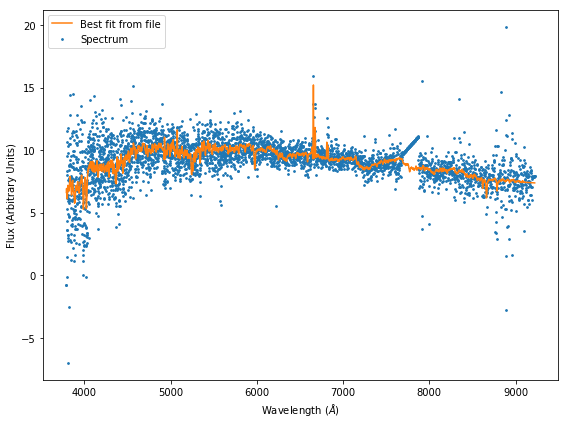

In [4]:
_ = plotSpectrum(spectrumDataTable, model=True)

Note that there is an issue with the data between 7500 and 8000 Å. Luckily, this corresponds to the region for which the `SkyFlux` column is zero, so we can filter it easily.

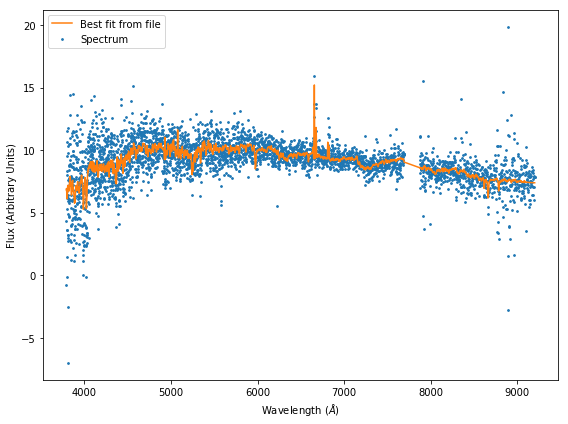

In [5]:
_ = plotSpectrum(spectrumDataTable, filterZeroSkyFlux=True, model=True)

Before moving on, we'll compute errors on the flux as the 0.2 times square root of the `SkyFlux` column as instructed.

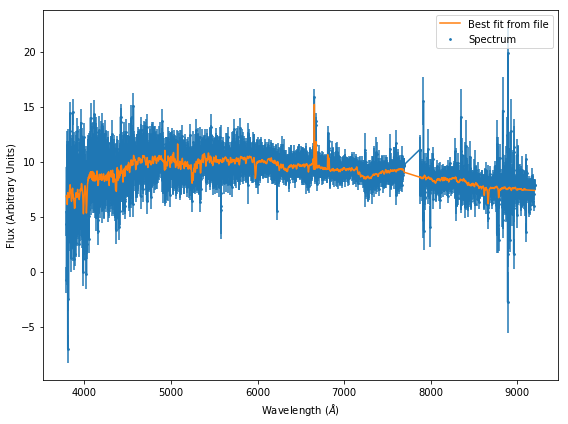

In [6]:
divideErrorsByTen = False
errorScaleFactors = [0.2, 0.02]
_ = spectrumDataTable["FluxError"] = errorScaleFactors[
    int(divideErrorsByTen)
] * np.sqrt(spectrumDataTable["SkyFlux"])
plotSpectrum(spectrumDataTable, filterZeroSkyFlux=True, errors=True, model=True)

Our basic **model** will comprise two Gaussian lines and a flat continuum component. We'll then model the **likelihood** of each spectral point assuming measurement errors are Gaussian and independent. We can boorw the appropriate formulation from [the `emcee` documentation](http://dfm.io/emcee/current/user/line/#maximum-likelihood-estimation), but the full derivation is trivial and we have seen it several times in previous assignments. Note the important distinction between our model of the **intrinsic spectrum** and our model of the imprefect **measurements** of that spectrum.

Let's define functions to compute the model components. Obviously, the _constant continuum_ component is trivial!

In [7]:
def gaussianModelComponent(x, norm, mean, sigma, normIntegral=False):
    if normIntegral:
        norm /= np.sqrt(2 * np.pi) * sigma
    return norm * np.exp(-0.5 * ((x - mean) / sigma) ** 2)


def constantModelComponent(x, norm):
    return np.ones_like(x) * norm

With our components defined we can define a function to assemble our composite model.

In [8]:
def spectralModel(
    wavelength,
    lineNorm,
    continuumNorm,
    lineSigma,
    lineStrengthRatio=0.9111,
    line1Lambda=6811.133,
    line2Lambda=6825.906,
):
    model = (
        constantModelComponent(wavelength, continuumNorm)
        + gaussianModelComponent(wavelength, lineNorm, line1Lambda, lineSigma)
        + gaussianModelComponent(
            wavelength, lineNorm * lineStrengthRatio, line2Lambda, lineSigma
        )
    )
    return model

Now it's time to define our log-likelihood function. For each spectral datum the likelihood is simply a gaussian centred on the true model value with $\sigma$ equal to the data error estimates. The total likelihood is then the sum of the log-likelihoods of the individual data. We also need to define _priors_ for each of our model parameters. We'll implement very simple _Top Hat_ priors on our parameters that return a special `-np.inf` value if a trial parameter falls outside the allowed bounds. The `-np.inf` value has a special meaning for `emcee` and returning it ensures that the sampler will not return to that region of parameter space. Note that **unlike** our previous experiences using `scipy.optimize.minimize` we actually need to return the log-liklihood and **not** the negative log-likelihood.

In [9]:
def logTophatPrior(x, xMin, xMax):
    if x < xMin or x > xMax:
        # return -inf if ouside bounds
        return -np.inf
    # return zero if inside bounds
    return 0.0


def logLikelihood(sample, *arguments):
    # Unpack the data and parameter bounds
    flux, wavelength, errors, lineNormBounds, continuumNormBounds, lineSigmaBounds = (
        arguments
    )
    # Unpack the model parameter values
    lineNorm, continuumNorm, lineSigma = sample

    prior = (
        logTophatPrior(lineNorm, *lineNormBounds)
        + logTophatPrior(continuumNorm, *continuumNormBounds)
        + logTophatPrior(lineSigma, *lineSigmaBounds)
    )
    if not np.isfinite(prior):
        # parameter bounds violated
        return -np.infty

    model = spectralModel(wavelength, lineNorm, continuumNorm, lineSigma)

    likelihood = -0.5 * np.sum(
        (((flux - model) / errors) ** 2) + np.log(2 * np.pi * errors ** 2)
    )

    return likelihood

Now let's isolate the segment of the spectrum we want to fit

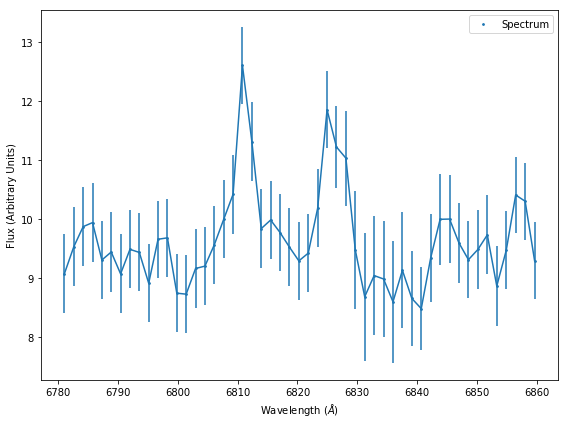

In [10]:
wavelengthSelection = (spectrumDataTable["Wavelength"] > 6780) & (
    spectrumDataTable["Wavelength"] < 6860
)
_ = plotSpectrum(
    spectrumDataTable[wavelengthSelection], filterZeroSkyFlux=True, errors=True
)

Before launching the MCMC sampler, lets run a basic likelihood fit using `scipy.optimize.minimize` to find some sensible starting positions for our MCMC walkers. This is only really sensible in this case because the dimensionality of our problem is small. In general, if you need MCMC to explore a high dimensional parameter space, then a standard gradient descent minimization will converge slowly, if at all. 

In [11]:
def mutatePriorBounds(
    bounds, squeezeFactor, shiftFactor, applySqueeze=False, applyShift=False
):
    boundsMean = np.mean(bounds)
    if applySqueeze:
        bounds = (bounds - boundsMean) / squeezeFactor + boundsMean
    if applyShift:
        bounds = bounds + shiftFactor * boundsMean
    return bounds


parameterNames = ["Line Norm.", "Cont. Norm", "Line Sigma"]

squeezePriors = False
shiftPriors = False

lineNormBounds = mutatePriorBounds(
    np.array([0, 5]), 2, 0.1, squeezePriors, shiftPriors
)
continuumNormBounds = mutatePriorBounds(
    np.array([5, 15]), 2, 0.1, squeezePriors, shiftPriors
)
lineSigmaBounds = mutatePriorBounds(
    np.array([0, 10]), 2, 0.1, squeezePriors, shiftPriors
)

In [12]:
def simpleLogLikelihood(sample, *arguments):
    # Unpack the data and parameter bounds
    flux, wavelength, errors = arguments
    # Unpack the model parameter values
    lineNorm, continuumNorm, lineSigma = sample

    model = spectralModel(wavelength, lineNorm, continuumNorm, lineSigma)

    likelihood = -0.5 * np.sum(
        (((flux - model) / errors) ** 2) + np.log(2 * np.pi * errors ** 2)
    )

    return -likelihood


fitResult = spopt.minimize(
    fun=simpleLogLikelihood,
    x0=[
        np.mean(lineNormBounds),
        np.mean(continuumNormBounds),
        np.mean(lineSigmaBounds),
    ],
    args=(
        spectrumDataTable["Flux"][wavelengthSelection],
        spectrumDataTable["Wavelength"][wavelengthSelection],
        spectrumDataTable["FluxError"][wavelengthSelection],
    ),
    bounds=[lineNormBounds, continuumNormBounds, lineSigmaBounds],
)

/Users/hughdickinson/anaconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


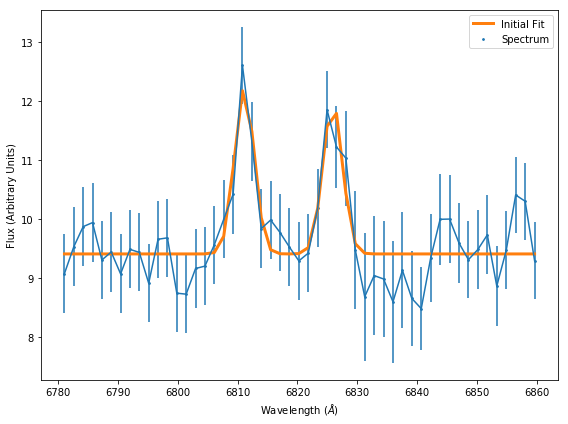

In [13]:
initFitAxes = plotSpectrum(
    spectrumDataTable[wavelengthSelection], filterZeroSkyFlux=True, errors=True
)

initFitAxes.plot(
    spectrumDataTable["Wavelength"][wavelengthSelection],
    spectralModel(
        spectrumDataTable["Wavelength"][wavelengthSelection], *fitResult.x
    ),
    label="Initial Fit",
    c="C1",
    lw=3,
)

initFitAxes.legend()
mplplot.tight_layout()

Not bad! Finally, we're ready to set up our MCMC fit. We'll use the [`emcee.EnsembleSampler` class](https://emcee.readthedocs.io/en/latest/user/sampler/) to do the actual sampling. Our model has three free parameters, so the MCMC algorithm needs to explore a three-dimensional parameter space. Since this is a fairly low-dimensional space we'll use 50 (relatively few) randomly initialized _walkers_.

In [14]:
sampler = emcee.EnsembleSampler(
    nwalkers=50,
    ndim=3,
    log_prob_fn=logLikelihood,
    args=(
        spectrumDataTable["Flux"][wavelengthSelection],
        spectrumDataTable["Wavelength"][wavelengthSelection],
        spectrumDataTable["FluxError"][wavelengthSelection],
        lineNormBounds,
        continuumNormBounds,
        lineSigmaBounds,
    ),
)

Copying the approach of the `emcee` documentation we'll initialze our MCMC walkers in a Gaussian ball around the best fit location we found using `scipy.optimize`. We'll pick a reasonably large ball so we can see how the walkers converge to the region of parameter space with the largets posterior probability. We'll need one start postion (3 coordinates) for each of our 50 walkers.

In [15]:
startPositions = fitResult.x + 0.1 * np.random.randn(50, 3)

Now let's run the MCMC sampler for 1000 steps and see what we get!

In [16]:
sampler.reset()
samplingResult = sampler.run_mcmc(
    initial_state=startPositions, nsteps=5000, progress=True
)

100%|██████████| 5000/5000 [02:23<00:00, 34.73it/s]


Now, let's plot the paths that our walkers explored during the sampling process. This will let us visually gauge an apropriate number of steps to discard as "burn in". We can then compute a more quantitatively motivated burn in length.

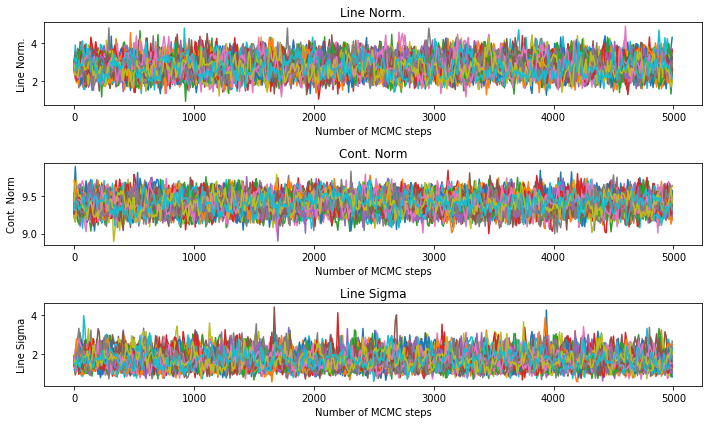

In [17]:
walkerTraceFigure, walkerTracePanels = mplplot.subplots(
    figsize=(10, 6), nrows=3, ncols=1
)

# print(sampler.get_chain().shape, np.swapaxes(sampler.get_chain(), 0, 2).shape)

for walkerTraces, walkerTracePanel, parameterName in zip(
    np.swapaxes(sampler.get_chain(), 0, 2),
    walkerTracePanels.flatten(),
    parameterNames,
):
    for walkerTrace in walkerTraces:
        walkerTracePanel.plot(
            # Only plot every 10th sample, but associate it with its proper step count
            np.arange(walkerTrace[::10].size) * 10,
            walkerTrace[::10],
        )
    walkerTracePanel.set_title(parameterName)
    walkerTracePanel.set_ylabel(parameterName)
    walkerTracePanel.set_xlabel("Number of MCMC steps")

mplplot.tight_layout()

It looks like at most 100 steps of burn in are required. We can verify this using the `get_autocorr_time()` method of our `emcee.EnsembleSampler` instance. This method computes a measure of how many steps it takes for a MCMC chain to lose its memory. If we choose a burn in length to be double the maximum autocorrelation time over all three parameters, we should be safe.

In [18]:
autoCorrelationTimes = sampler.get_autocorr_time()
burnInSteps = int(2 * autoCorrelationTimes.max())
print(
    "Autocorrelation Times:",
    autoCorrelationTimes,
    "Maximum:",
    autoCorrelationTimes.max(),
    "Burn in:",
    burnInSteps,
    sep="\n",
)

Autocorrelation Times:
[37.84815885 37.09501692 35.97241093]
Maximum:
37.84815884642322
Burn in:
75


Now let's generate some plots of individual walker paths in the two dimensional spaces defined by distinct pairs of the model parameters.

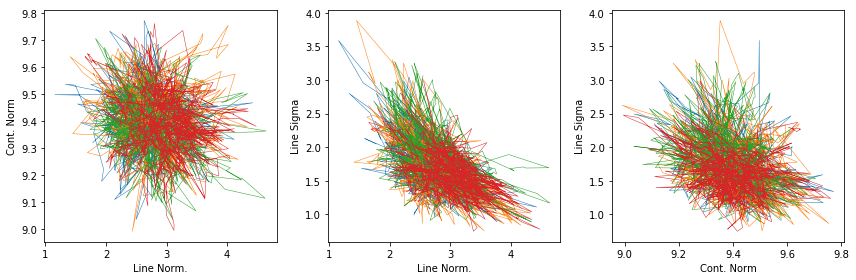

In [19]:
paramIndexPairs = list(itertools.combinations(range(3), 2))

twoDimWalkerPathFigureShape = np.array((len(paramIndexPairs), 1))
twoDimWalkerPathFigure, twoDimWalkerPathPanels = mplplot.subplots(
    figsize=4 * twoDimWalkerPathFigureShape,
    ncols=twoDimWalkerPathFigureShape[0],
    nrows=twoDimWalkerPathFigureShape[1],
)

startingChain = np.rollaxis(sampler.get_chain()[: 20 * burnInSteps, :4, :], 1)


for paramIndexPair, twoDimWalkerPathPanel in zip(
    paramIndexPairs, twoDimWalkerPathPanels
):
    for walkerTrace in startingChain:
        twoDimWalkerPathPanel.plot(*walkerTrace[:, paramIndexPair].T, lw=0.5)
        twoDimWalkerPathPanel.set_xlabel(parameterNames[paramIndexPair[0]])
        twoDimWalkerPathPanel.set_ylabel(parameterNames[paramIndexPair[1]])

mplplot.tight_layout()

We can use the `corner` package to automatically generate plots of the joint and marginal posterior distributions of that our MCMC sampler has approximated. First, let's get a pruned copy of the sampling data with the burn in steps removed. Specifying `flat=True` combines the traces for all walkers.

In [20]:
postBurnInChain = sampler.get_chain(discard=burnInSteps, flat=True)

Now we can plot the distributions. We'll use the `truths` argument to overplot the best fit values we derived using gradient descent as red lines.

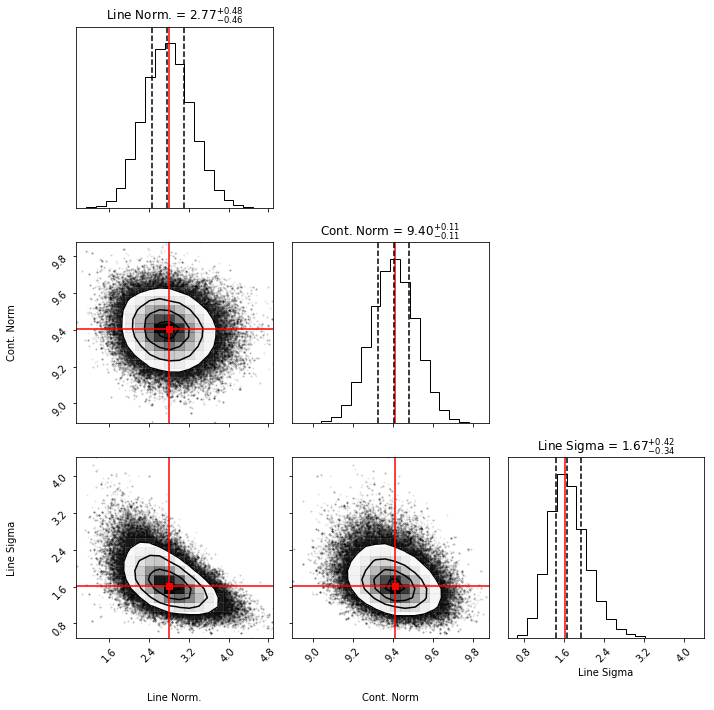

In [21]:
mcmcDistFigure, mcmcDistPanels = mplplot.subplots(
    figsize=(10, 10),
    nrows=postBurnInChain.shape[1],
    ncols=postBurnInChain.shape[1],
)
mcmcDistFigure = corner.corner(
    postBurnInChain,
    labels=parameterNames,
    fig=mcmcDistFigure,
    show_titles=True,
    quantiles=[0.25, 0.50, 0.75],
    truths=fitResult.x,
    truth_color="r",
)
mplplot.tight_layout()

Finally, lets compute the median and $\sim1\sigma$ quantiles for each of the fit parameters, then compare the implied model with the one we derived using gradient descent.

In [22]:
parameterPercentiles = np.percentile(
    q=100 * np.array([0.5 * (1 - 0.68), 0.5, 1 - 0.5 * (1 - 0.68)]),
    a=postBurnInChain,
    axis=0,
)

In [23]:
parameterMedians = parameterPercentiles[1, :]
parameterCredibleIntervals = parameterPercentiles[[0, 2], :].T

resultString = ", ".join(
    [
        "{} = ${:.2f}^{{+{:.3f}}}_{{-{:.3f}}}$".format(
            parName, central, upper - central, central - lower
        )
        for parName, (lower, upper, central) in zip(
            parameterNames, parameterPercentiles.T
        )
    ]
)

print(resultString)
Latex(resultString)

Line Norm. = $3.26^{+-0.482}_{-0.940}$, Cont. Norm = $9.51^{+-0.112}_{-0.224}$, Line Sigma = $2.09^{+-0.419}_{-0.759}$


<IPython.core.display.Latex object>

We can compute the envelope of models that are consistent with the credible parameter ranges. First we need to compute all possible parameter combinations. This is called an _Cartesian product_ and the `itertools.product` function will compute it for us. 

In [24]:
modelWavelengthGrid = np.linspace(
    spectrumDataTable["Wavelength"][wavelengthSelection].min(),
    spectrumDataTable["Wavelength"][wavelengthSelection].max(),
    100,
)

credibleModels = np.array(
    [
        spectralModel(modelWavelengthGrid, *paramSet)
        for paramSet in itertools.product(*parameterCredibleIntervals)
    ]
)

lowerEnvelope = np.amin(credibleModels, axis=0)
upperEnvelope = np.amax(credibleModels, axis=0)

Finally let's make the plot of our final MCMC fit.

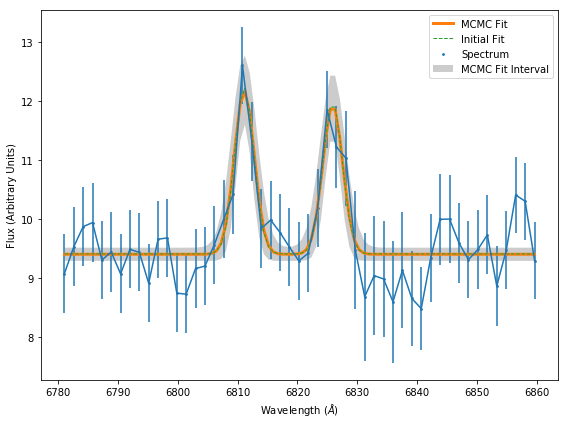

In [25]:
mcmcFitAxes = plotSpectrum(
    spectrumDataTable[wavelengthSelection], filterZeroSkyFlux=True, errors=True
)

mcmcFitAxes.plot(
    modelWavelengthGrid,
    spectralModel(modelWavelengthGrid, *parameterMedians),
    label="MCMC Fit",
    c="C1",
    lw=3,
)

mcmcFitAxes.fill_between(
    modelWavelengthGrid,
    lowerEnvelope,
    upperEnvelope,
    label="MCMC Fit Interval",
    facecolor="grey",
    alpha=0.4,
)

mcmcFitAxes.plot(
    modelWavelengthGrid,
    spectralModel(modelWavelengthGrid, *fitResult.x),
    label="Initial Fit",
    c="C2",
    lw=1,
    ls="--",
)

mcmcFitAxes.legend()
mplplot.tight_layout()

Now we can address the problem-related questions:
* _What happens if you reduce your errors by a factor of 10?_
    * The best fit results using original errors
        * Line Norm. = $3.23^{+-0.47}_{-0.92}$
        * Cont. Norm = $9.52^{+-0.11}_{-0.22}$
        * Line Sigma = $2.09^{+-0.42}_{-0.76}$
    * The best fit results using reduced errors
        * Line Norm. = $2.86^{+-0.046}_{-0.093}$
        * Cont. Norm = $9.42^{+-0.011}_{-0.022}$
        * Line Sigma = $1.66^{+-0.037}_{-0.072}$
    * It is evident that the best fit parameter values change (albeit consistent within the original uncertainties) but the parameter uncertainties decrease by a factor of 10, thereby excluding the best fit values using the initial errors.
* _What happens when you change the prior?_
    * Changing the prior has a significant effect if it excludes the region of parameter space containing the best fit values, leading to spurious resluts or very misleading error estimates or indications of corellation. Choosing narrower prior ranges  can skew the posterior distribution by biassing the trial locations selected by the MCMC walkers.
* _What happens when you change the initial positions of your walkers?_
    * In isolation, changing the initial walker positions has little effect on the ultimate result, **unless**:
        * All walkers are initialized at the MLE location. In this case they will not explore the parameter space widely and the estimated errors will be too small.
        * All walkers are initialized very far from the MLE location. In this case the chain may eventually converge, but the required number of burn in steps will probably increase.  
* _What happens when you change the number of walkers?_
    * Decreasing the number of walkers too much can impact results and reduce the accuracy of the final result. Since our model is only three dimensional only a modest number of walkers is required in order to adequately explore the parameter space, and therefore increasing the number of walkers excessively only inreases the runtime!
* _How long of a 'burn-in' phase is required?_
    * We estimated a burn in length of 76 steps.
* _Is there any correlation between parameters?_
    * We can compute the correlation coefficients between the parameter values sampled by the post-burn-in walkers

In [26]:
deepChain = sampler.get_chain(discard=burnInSteps, flat=True).T
parameterCombinations = itertools.combinations(range(deepChain.shape[0]), 2)
for parameterCombination in parameterCombinations:
    pearsonCorrelationResult = spstats.pearsonr(
        deepChain[parameterCombination[0]], deepChain[parameterCombination[1]]
    )
    spearmannCorrelationResult = spstats.spearmanr(
        deepChain[parameterCombination[0]], deepChain[parameterCombination[1]]
    )
    print(
        "{} -> {}:\n{}\n{}".format(
            parameterNames[parameterCombination[0]],
            parameterNames[parameterCombination[1]],
            pearsonCorrelationResult,
            spearmannCorrelationResult,
        )
    )

Line Norm. -> Cont. Norm:
(-0.14066532170686902, 0.0)
SpearmanrResult(correlation=-0.13492384299941365, pvalue=0.0)
Line Norm. -> Line Sigma:
(-0.5420352793533717, 0.0)
SpearmanrResult(correlation=-0.5280044506259476, pvalue=0.0)
Cont. Norm -> Line Sigma:
(-0.3149325998568828, 0.0)
SpearmanrResult(correlation=-0.3065792574088638, pvalue=0.0)


So, despite the appearance of some corellation in the lower left panel of our corner plot, there is no evidence for correllation between the parameters.